# ICT4SM GOUP 14 LAB 2

In [4]:
import pymongo as pm 
from pymongo import MongoClient
import pprint 
import datetime
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from datetime import timedelta

from sklearn.neighbors import KernelDensity
import numpy as np


client = pm.MongoClient('bigdatadb.polito.it:27017',
                        ssl=True,
                        authSource = 'carsharing',
                        username = 'ictts',
                        password ='Ict4SM22!',
                        tlsAllowInvalidCertificates=True)



db_car2go = client["carsharing"]["ictts_PermanentBookings"]
db_enjoy = client["carsharing"]["ictts_enjoy_PermanentBookings"]



## Tasks

### 1 For carsharing data, check if the booking records requires to be filtered to get valid rentals. Derive the OD matrix based on the zones of Torino

Filtering function

In [38]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Progress bar
from datetime import datetime

# Load zones from GeoJSON file
zones = gpd.read_file("./Zone/TorinoZonescol.geojson").to_crs("EPSG:4326")

# Fetch data in small batches with progress tracking
def fetch_all_data_in_batches(collection, collection_name, batch_size=10000):
    cursor = collection.find({}, {"init_loc": 1, "final_loc": 1, "init_time": 1}, no_cursor_timeout=True)
    with tqdm(desc=f"Fetching {collection_name} data", unit="records") as pbar:
        try:
            batch_data = []
            for document in cursor:
                batch_data.append(document)
                pbar.update(1)
                if len(batch_data) >= batch_size:
                    yield pd.DataFrame(batch_data)
                    batch_data = []
            if batch_data:
                yield pd.DataFrame(batch_data)
        finally:
            cursor.close()

# Filter valid rentals (init_loc and final_loc must be distinct)
def filter_valid_rentals(df):
    return df[df["init_loc"] != df["final_loc"]]

# Assign zones to trips
def assign_zones(df, zones):
    if "zone_id" not in zones.columns:
        zones["zone_id"] = range(len(zones))

    df["ORI_ZONE"] = gpd.sjoin(
        gpd.GeoDataFrame(df, geometry=df["init_loc"].apply(lambda loc: Point(*loc['coordinates'])), crs="EPSG:4326"),
        zones, how="left", predicate="intersects"
    )["zone_id"]

    df["DST_ZONE"] = gpd.sjoin(
        gpd.GeoDataFrame(df, geometry=df["final_loc"].apply(lambda loc: Point(*loc['coordinates'])), crs="EPSG:4326"),
        zones, how="left", predicate="intersects"
    )["zone_id"]

    return df.dropna(subset=["ORI_ZONE", "DST_ZONE"]).reset_index(drop=True)

# Add hour, day, and date columns based on init_time
def add_time_columns(df):
    df["hour"] = pd.to_datetime(df["init_time"], unit="s").dt.hour
    df["day"] = pd.to_datetime(df["init_time"], unit="s").dt.weekday
    df["date"] = pd.to_datetime(df["init_time"], unit="s").dt.date  # Adding date column
    return df

# Normalize OD matrix
def normalize_od_matrix_bidirectional(df):
    pivot = df.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="count", fill_value=0)

    for _ in range(10):
        # Normalize rows
        row_sums = pivot.sum(axis=1)
        pivot = pivot.div(row_sums, axis=0).fillna(0)

        # Normalize columns
        col_sums = pivot.sum(axis=0)
        pivot = pivot.div(col_sums, axis=1).fillna(0)

    return pivot.stack().reset_index(name="normalized_count")

# Generate OD matrix with bidirectional normalization
def generate_od_matrix_with_bidirectional_normalization(df, zones):
    df_with_zones = assign_zones(df, zones)
    df_with_zones = add_time_columns(df_with_zones)

    # Group by Origin, Destination, Hour, Day, and Date
    od_matrix = df_with_zones.groupby(["ORI_ZONE", "DST_ZONE", "hour", "day", "date"]).size().reset_index(name="count")
    normalized_matrix = normalize_od_matrix_bidirectional(od_matrix)
    normalized_matrix = pd.merge(normalized_matrix, od_matrix, on=["ORI_ZONE", "DST_ZONE"], how="left")
    return normalized_matrix

# Save OD matrix to CSV
def save_od_matrix_to_csv(od_matrix, filename):
    od_matrix.to_csv(filename, index=False)

# Process and save OD matrices for Car2GO and Enjoy
def process_and_save_matrices(db_collection, collection_name, zones, output_file):
    all_od_matrices = []
    for batch in fetch_all_data_in_batches(db_collection, collection_name):
        filtered_batch = filter_valid_rentals(batch)
        od_matrix = generate_od_matrix_with_bidirectional_normalization(filtered_batch, zones)
        all_od_matrices.append(od_matrix)

    final_od_matrix = pd.concat(all_od_matrices, ignore_index=True)
    save_od_matrix_to_csv(final_od_matrix, output_file)
    print(f"Saved {collection_name} OD matrix to {output_file}")

# Processing Car2GO and Enjoy data
print("Processing Car2GO data...")
process_and_save_matrices(db_car2go, "Car2GO", zones, "car2go_od_matrix.csv")

print("Processing Enjoy data...")
process_and_save_matrices(db_enjoy, "Enjoy", zones, "enjoy_od_matrix.csv")

print("Processing completed.")


C:\Users\sartr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pymongo\synchronous\collection.py:1920: UserWarning: use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://mongodb.com/docs/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout-overrides-nocursortimeout
  return Cursor(self, *args, **kwargs)


Processing Car2GO data...


Fetching Car2GO data: 121667records [00:41, 2950.66records/s]
C:\Users\sartr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pymongo\synchronous\collection.py:1920: UserWarning: use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://mongodb.com/docs/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout-overrides-nocursortimeout
  return Cursor(self, *args, **kwargs)


Saved Car2GO OD matrix to car2go_od_matrix.csv
Processing Enjoy data...


Fetching Enjoy data: 97173records [00:12, 7709.95records/s] 


Saved Enjoy OD matrix to enjoy_od_matrix.csv
Processing completed.


### a. Compute OD matrices on different periods (weekdays vs weekends, daytime vs night-time). Is it possible to spot any difference? 

Plotting Car2GO OD matrices for different periods...


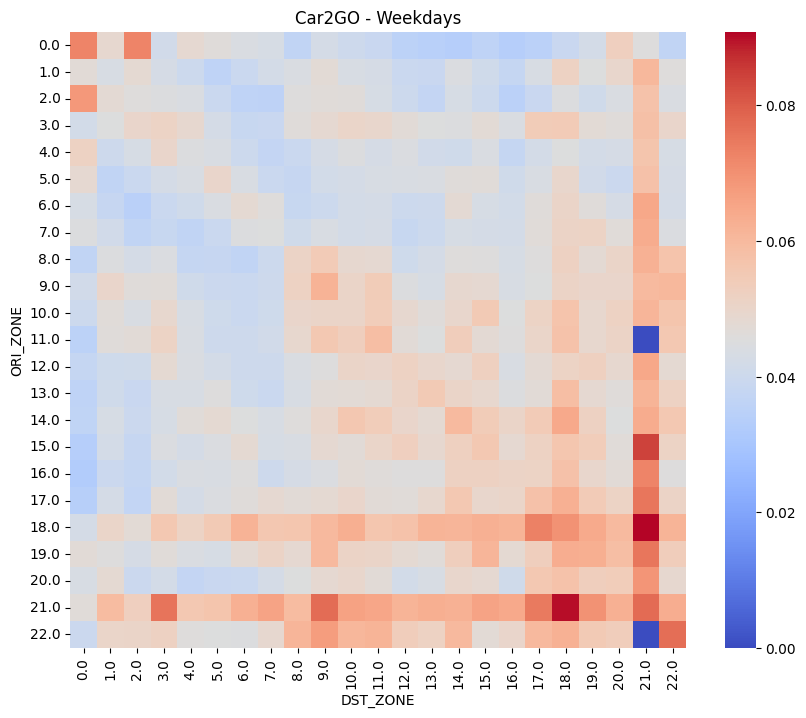

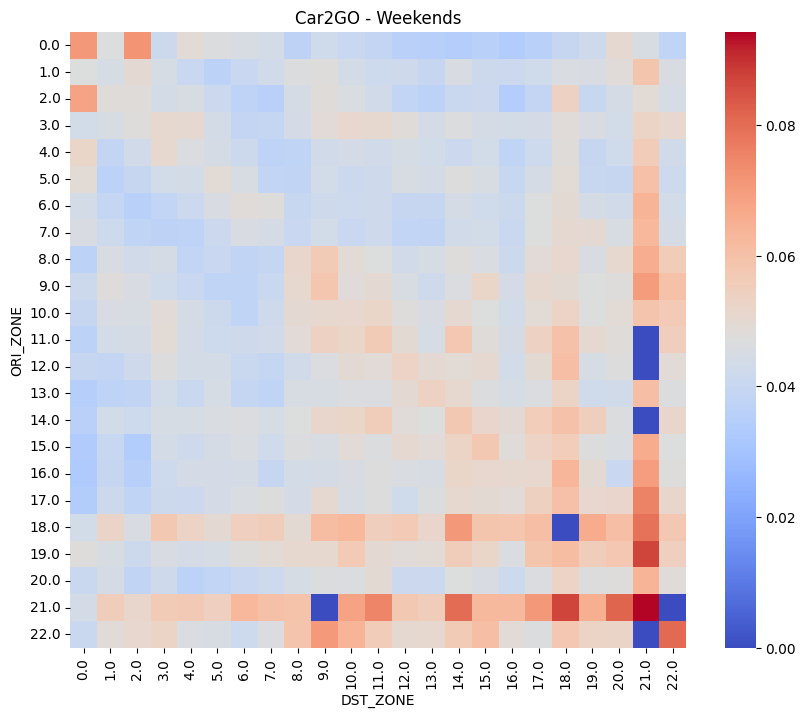

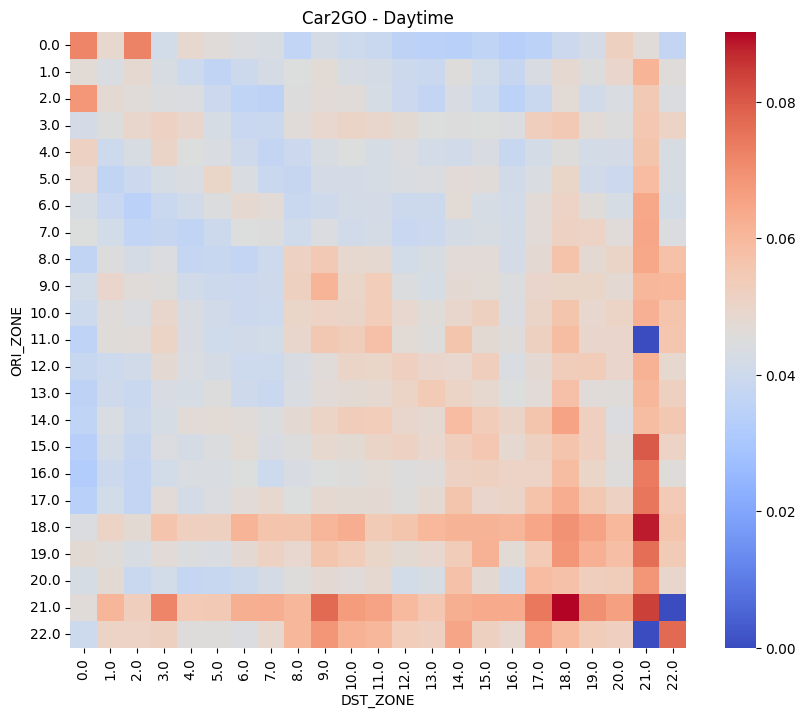

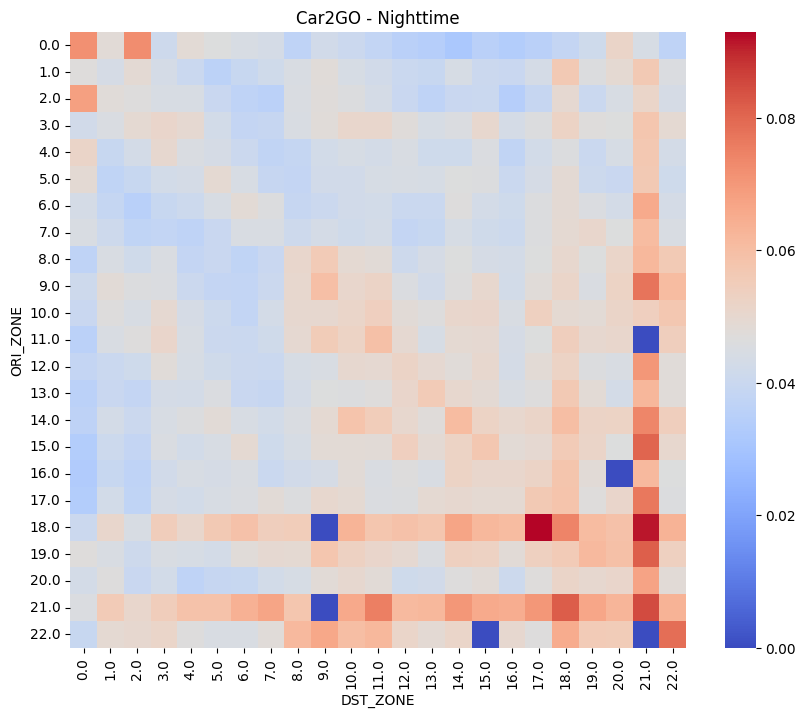

Plotting Car2GO OD matrices for different weeks...


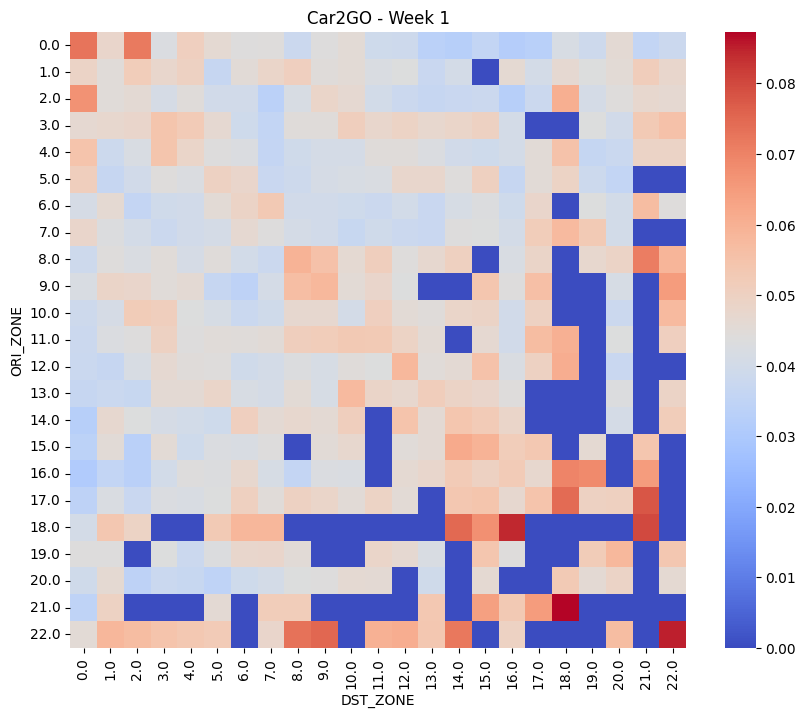

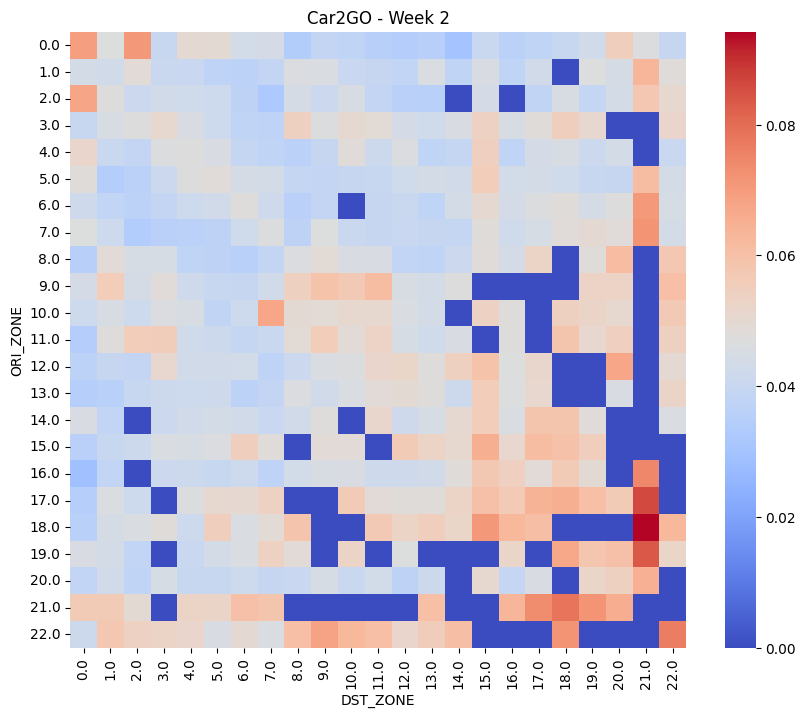

Plotting comparison between Car2GO and Enjoy...


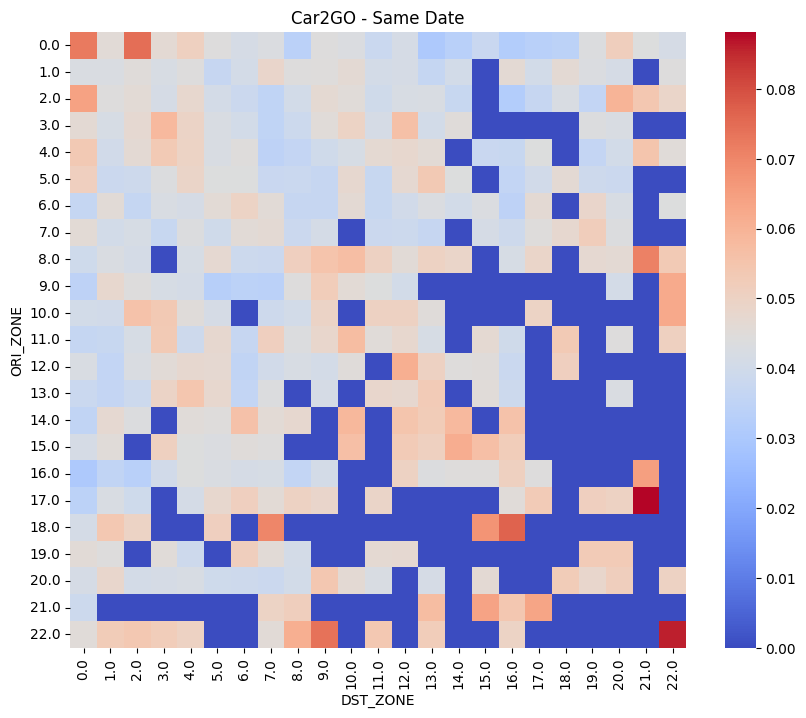

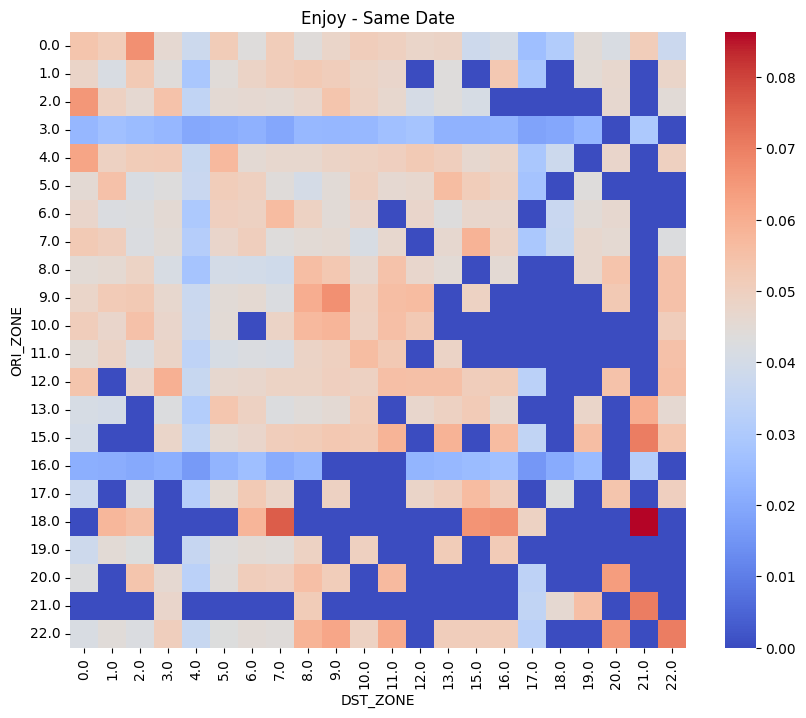

Processing and plotting completed.


In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

def filter_od_matrix(df, day_filter=None, hour_filter=None, date_filter=None):
    if day_filter is not None:
        df = df[df["day"].isin(day_filter)]
    if hour_filter is not None:
        if hour_filter[0] < hour_filter[1]:  # Normal case, e.g., 6:00 to 18:00
            df = df[(df["hour"] >= hour_filter[0]) & (df["hour"] < hour_filter[1])]
        else:  # Overnight case, e.g., 18:00 to 6:00
            df = df[(df["hour"] >= hour_filter[0]) | (df["hour"] < hour_filter[1])]
    if date_filter is not None:
        df = df[(pd.to_datetime(df["date"]).isin(pd.to_datetime(date_filter)))]
    return df

def plot_od_matrix(df, title):
    if df.empty:
        print(f"No data available for {title}. Skipping plot.")
        return

    pivot = df.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="normalized_count", fill_value=0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, cmap="coolwarm", square=True, cbar=True)
    plt.title(title)
    plt.xlabel("DST_ZONE")
    plt.ylabel("ORI_ZONE")
    plt.show()

# Load OD matrices
car2go_od_matrix = pd.read_csv("car2go_od_matrix.csv")
enjoy_od_matrix = pd.read_csv("enjoy_od_matrix.csv")

# A. Compute OD matrices for different periods (weekdays vs weekends, daytime vs nighttime)
print("Plotting Car2GO OD matrices for different periods...")
weekday_od = filter_od_matrix(car2go_od_matrix, day_filter=range(0, 5))
plot_od_matrix(weekday_od, "Car2GO - Weekdays")

weekend_od = filter_od_matrix(car2go_od_matrix, day_filter=[5, 6])
plot_od_matrix(weekend_od, "Car2GO - Weekends")

daytime_od = filter_od_matrix(car2go_od_matrix, hour_filter=(6, 18))
plot_od_matrix(daytime_od, "Car2GO - Daytime")

nighttime_od = filter_od_matrix(car2go_od_matrix, hour_filter=(18, 6))
plot_od_matrix(nighttime_od, "Car2GO - Nighttime")

# B. Compute OD matrices for different dates (e.g., weekdays in two different weeks)
print("Plotting Car2GO OD matrices for different weeks...")
week1_dates = ['2017-10-21', '2017-10-28']
week2_dates = ['2017-09-21', '2017-09-28']
week1_od = filter_od_matrix(car2go_od_matrix, date_filter=week1_dates)
week2_od = filter_od_matrix(car2go_od_matrix, date_filter=week2_dates)

plot_od_matrix(week1_od, "Car2GO - 2017-10-21 to 2017-10-28")
plot_od_matrix(week2_od, "Car2GO - 2017-9-21 to 2017-9-28")

# C. Compare OD matrices for the same date between Car2GO and Enjoy
print("Plotting comparison between Car2GO and Enjoy...")
same_date = ['2017-10-28']
same_date_car2go = filter_od_matrix(car2go_od_matrix, date_filter=same_date)
same_date_enjoy = filter_od_matrix(enjoy_od_matrix, date_filter=same_date)

plot_od_matrix(same_date_car2go, "Car2GO - Same Date")
plot_od_matrix(same_date_enjoy, "Enjoy - Same Date")

print("Processing and plotting completed.")

### b. Consider the same period, compute OD matrices on different dates (e.g., OD matrices of weekdays in two different weeks). is it possible to spot any difference? How does the different compare with different periods? 

### c. Consider the same period, compute OD matrices on same date for Car2GO and Enjoy. Is there any difference between different platforms? How does it compare with previous ones? 

## 2. Derive metrics to compute the similarity between OD matrices.

Plotting Car2GO OD matrices for different periods...


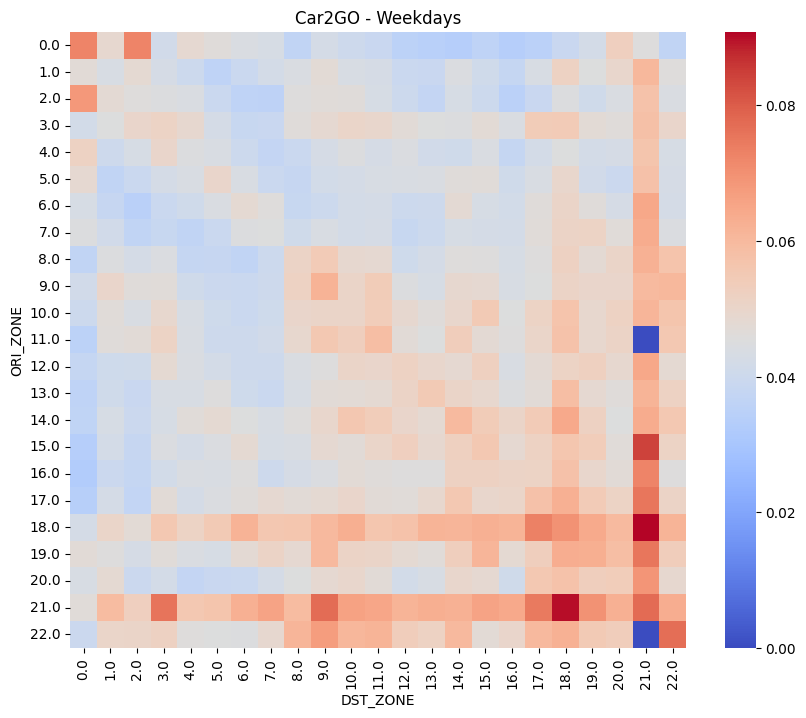

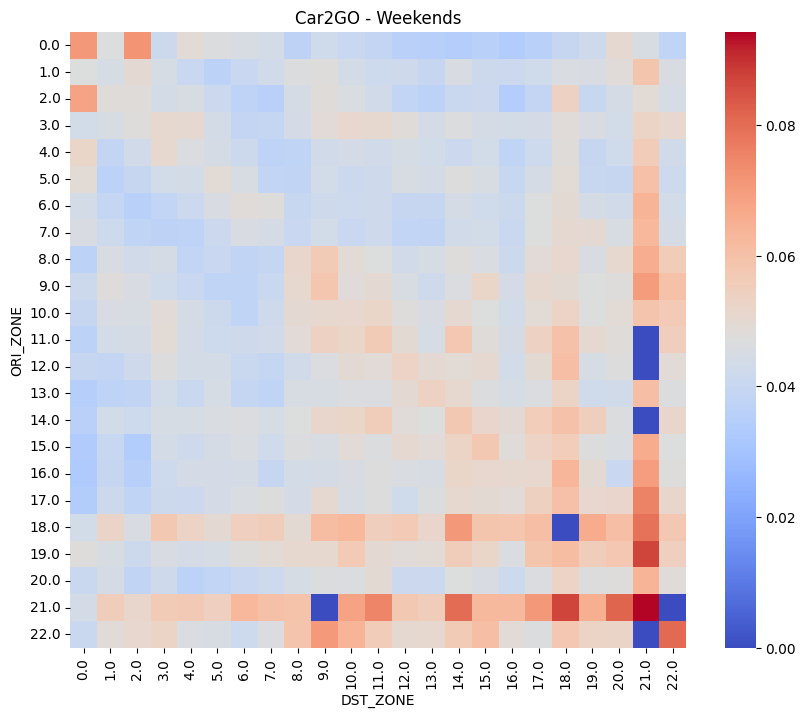

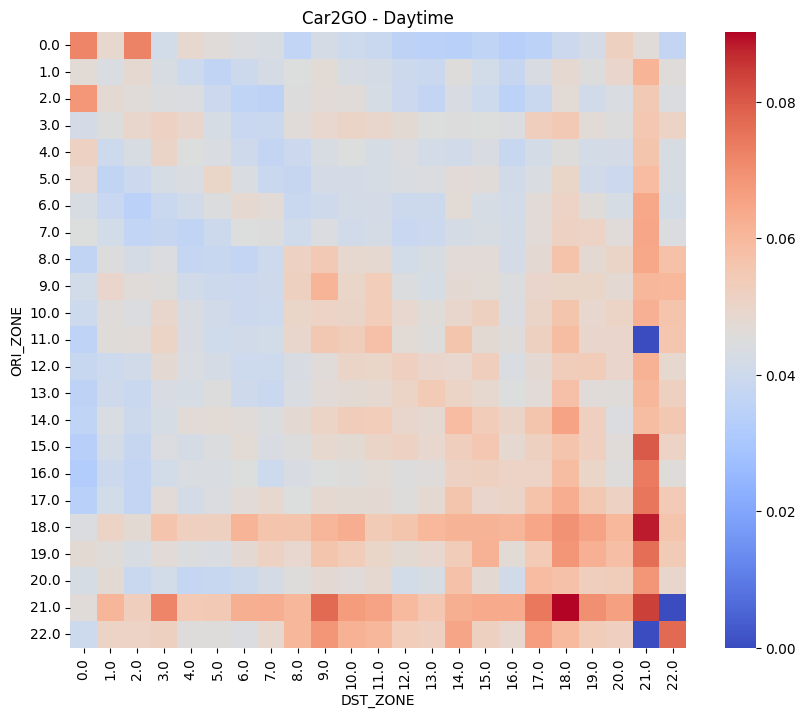

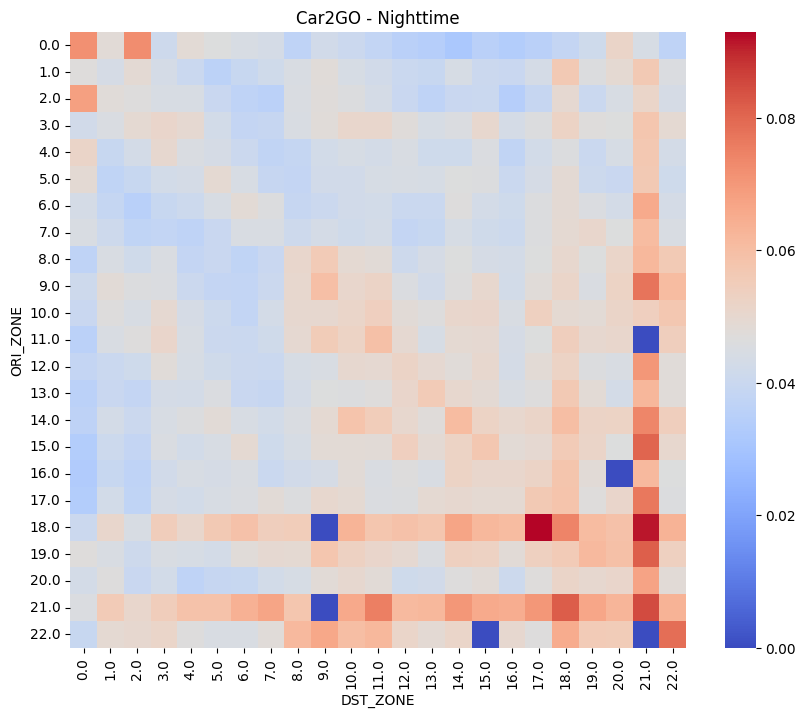

Similarity between Weekdays and Weekends: {'Absolute Difference': np.float64(1.386429145000004), 'Mean Squared Error': np.float64(5.4671615799426404e-05), 'Root Mean Squared Error': np.float64(0.007394025682902813)}
Similarity between Daytime and Nighttime: {'Absolute Difference': np.float64(1.1289910155842156), 'Mean Squared Error': np.float64(4.458424492622119e-05), 'Root Mean Squared Error': np.float64(0.006677143470543462)}
Plotting Car2GO OD matrices for different weeks...


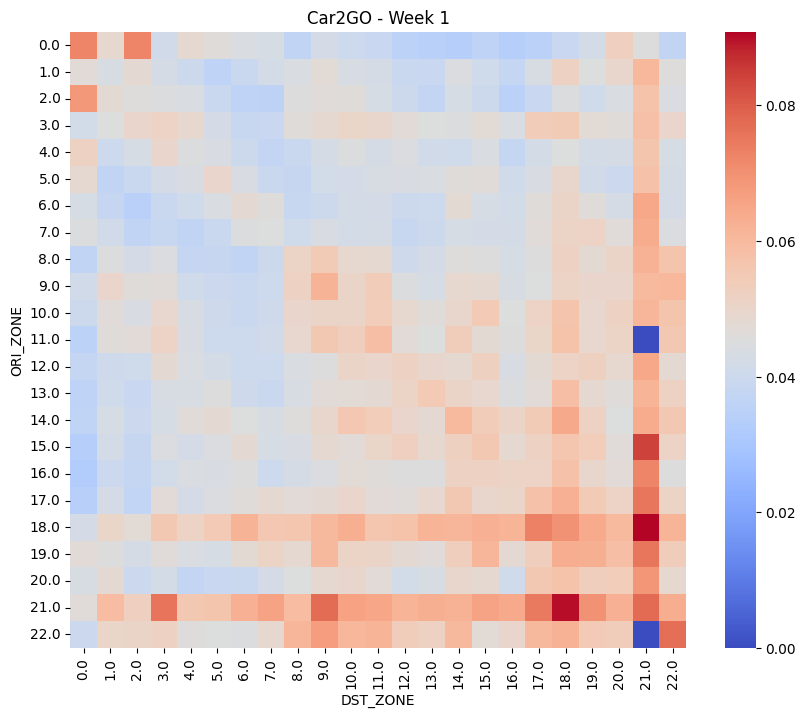

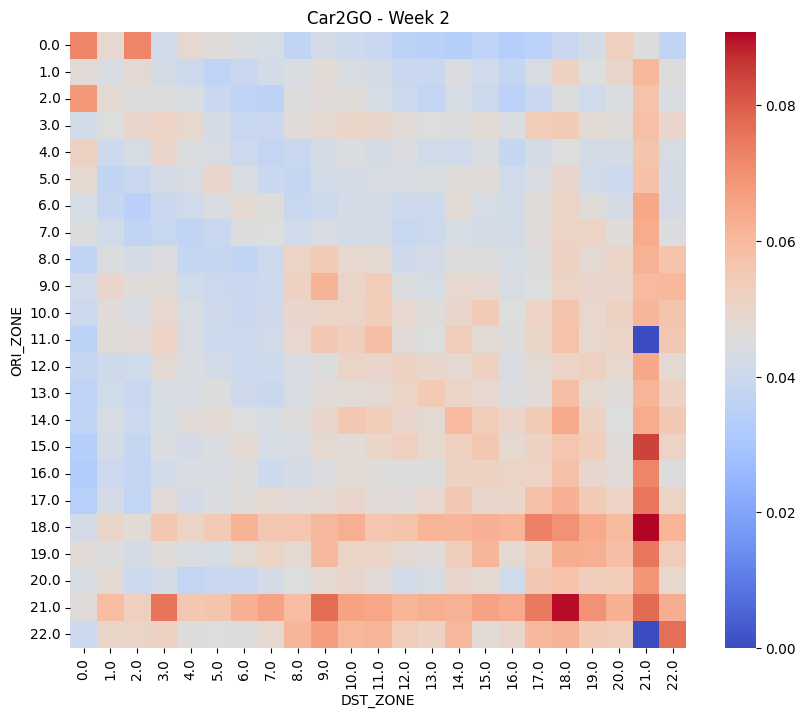

Similarity between Week 1 and Week 2: {'Absolute Difference': np.float64(0.0), 'Mean Squared Error': np.float64(0.0), 'Root Mean Squared Error': np.float64(0.0)}
Plotting comparison between Car2GO and Enjoy...


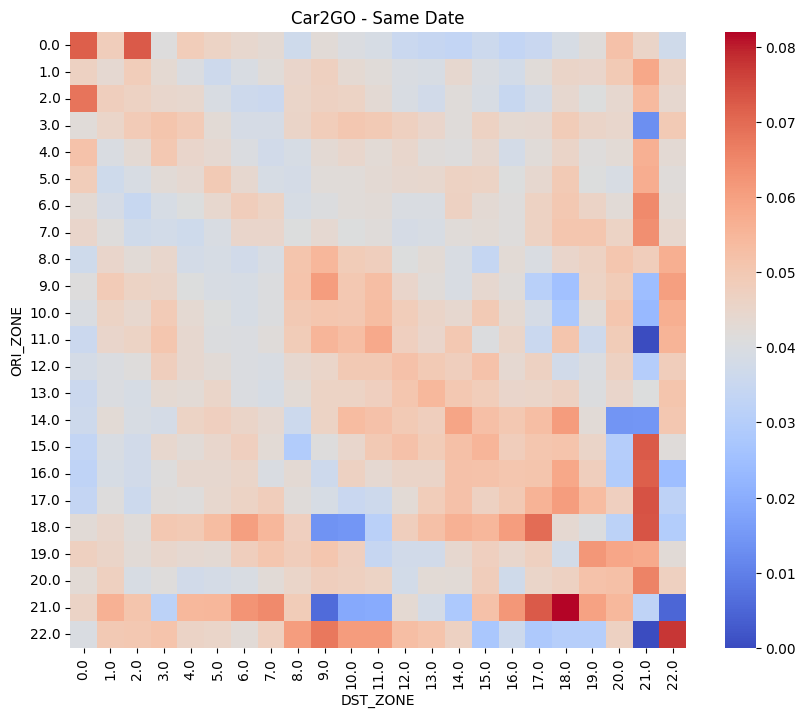

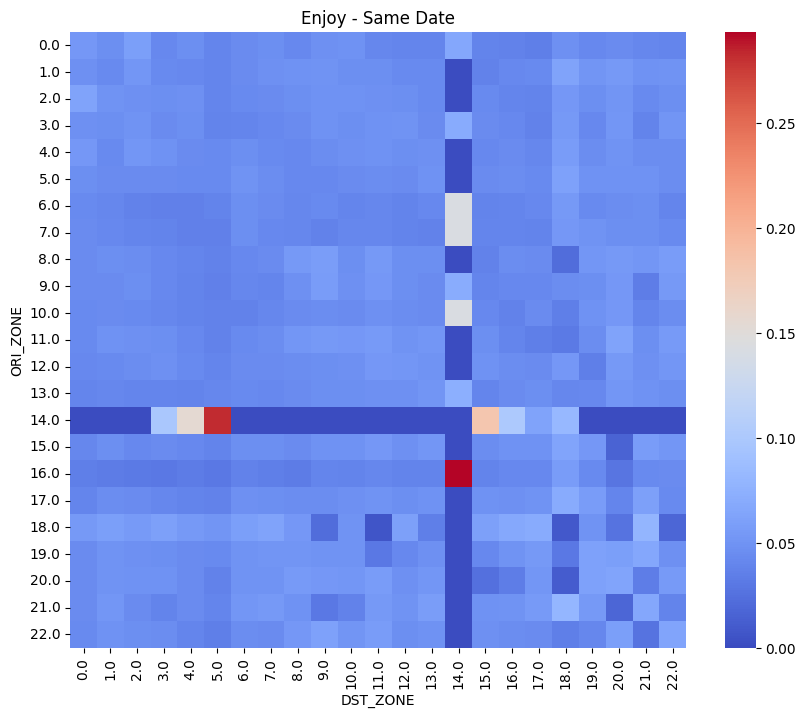

Similarity between Car2GO and Enjoy on the same date: {'Absolute Difference': np.float64(5.4055025676165265), 'Mean Squared Error': np.float64(0.0005241729219362016), 'Root Mean Squared Error': np.float64(0.02289482303788788)}
Processing completed.


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load OD matrices
car2go_od_matrix = pd.read_csv("car2go_od_matrix.csv")
enjoy_od_matrix = pd.read_csv("enjoy_od_matrix.csv")


# Compute similarity metrics
def compute_similarity_metrics(matrix_a, matrix_b):
    # Ensure the matrices have the same structure
    zones = sorted(set(matrix_a["ORI_ZONE"]).union(matrix_b["ORI_ZONE"]))
    combined_a = matrix_a.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="normalized_count", fill_value=0).reindex(index=zones, columns=zones, fill_value=0)
    combined_b = matrix_b.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="normalized_count", fill_value=0).reindex(index=zones, columns=zones, fill_value=0)

    # Flatten matrices
    a_flat = combined_a.values.flatten()
    b_flat = combined_b.values.flatten()

    # Compute metrics
    absolute_difference = np.sum(np.abs(a_flat - b_flat))
    mse = np.mean((a_flat - b_flat) ** 2)
    rmse = np.sqrt(mse)

    return {
        "Absolute Difference": absolute_difference,
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse
    }

# A. Compute OD matrices for different periods (weekdays vs weekends, daytime vs nighttime)
print("Plotting Car2GO OD matrices for different periods...")
weekday_od = filter_od_matrix(car2go_od_matrix, day_filter=range(0, 5))
weekend_od = filter_od_matrix(car2go_od_matrix, day_filter=[5, 6])
daytime_od = filter_od_matrix(car2go_od_matrix, hour_filter=(6, 18))
nighttime_od = filter_od_matrix(car2go_od_matrix, hour_filter=(18, 6))

# Plot matrices
plot_od_matrix(weekday_od, "Car2GO - Weekdays")
plot_od_matrix(weekend_od, "Car2GO - Weekends")
plot_od_matrix(daytime_od, "Car2GO - Daytime")
plot_od_matrix(nighttime_od, "Car2GO - Nighttime")

# Compute and print similarity metrics
similarity_weekday_weekend = compute_similarity_metrics(weekday_od, weekend_od)
print("Similarity between Weekdays and Weekends:", similarity_weekday_weekend)

similarity_daytime_nighttime = compute_similarity_metrics(daytime_od, nighttime_od)
print("Similarity between Daytime and Nighttime:", similarity_daytime_nighttime)

# B. Compute OD matrices for different dates (e.g., weekdays in two different weeks)
print("Plotting Car2GO OD matrices for different weeks...")
week1_od = filter_od_matrix(car2go_od_matrix, day_filter=range(0, 5))  # Replace with actual Week 1 filtering
week2_od = filter_od_matrix(car2go_od_matrix, day_filter=range(0, 5))  # Replace with actual Week 2 filtering

plot_od_matrix(week1_od, "Car2GO - Week 1")
plot_od_matrix(week2_od, "Car2GO - Week 2")

similarity_weeks = compute_similarity_metrics(week1_od, week2_od)
print("Similarity between Week 1 and Week 2:", similarity_weeks)

# C. Compare OD matrices for the same date between Car2GO and Enjoy
print("Plotting comparison between Car2GO and Enjoy...")
same_date_car2go = filter_od_matrix(car2go_od_matrix)  # Replace with actual date filtering logic
same_date_enjoy = filter_od_matrix(enjoy_od_matrix)   # Replace with actual date filtering logic

plot_od_matrix(same_date_car2go, "Car2GO - Same Date")
plot_od_matrix(same_date_enjoy, "Enjoy - Same Date")

similarity_car2go_enjoy = compute_similarity_metrics(same_date_car2go, same_date_enjoy)
print("Similarity between Car2GO and Enjoy on the same date:", similarity_car2go_enjoy)

print("Processing completed.")


## 3. Compute OD matrices for unipol and IMQ

In [51]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load IMQ Tables
spostamenti = pd.read_csv('./IMQData/spostamenti.csv')  # Replace with actual file path
interviste = pd.read_csv('./IMQData/interviste.csv')    # Replace with actual file path
tab_sesso = pd.read_csv('./IMQData/tab_sesso.csv')     # Replace with actual file path

# Step 1: Merge Tables
# Join Spostamenti and Interviste tables
imq_data = pd.merge(spostamenti, interviste, on='ID_INT', how='inner')

# Inspect column names after merging
print("Merged dataset columns:", imq_data.columns)

# Step 2: Select Correct Columns
# Use the correct columns based on the headers after merging
imq_data['SESSO'] = imq_data['SESSO_y']  # Gender from Interviste
imq_data['FASCIA_ETA'] = imq_data['FASCIA_ETA_y']  # Age group from Interviste
imq_data['COD_ZONA_PAR'] = imq_data['COD_ZONA_PAR']  # Origin zone from Spostamenti
imq_data['COD_ZONA_ARR'] = imq_data['COD_ZONA_ARR']  # Destination zone from Spostamenti

# Drop rows with missing zones (optional, for safety)
imq_data = imq_data.dropna(subset=['COD_ZONA_PAR', 'COD_ZONA_ARR'])

# Map Gender using Tab_Sesso
gender_mapping = dict(zip(tab_sesso['Cod_Sex'], tab_sesso['Label']))
imq_data['SESSO'] = imq_data['SESSO'].map(gender_mapping)

# Step 3: Define Functions
def compute_od_matrix(data, origin_col, destination_col, group_col=None):
    """
    Computes an OD matrix.
    Args:
        data: DataFrame containing trip data
        origin_col: Column name for origin zones
        destination_col: Column name for destination zones
        group_col: Column for subgroup filtering (e.g., gender/age)
    Returns:
        OD Matrix (DataFrame)
    """
    if group_col:
        od_matrix = data.groupby([origin_col, destination_col, group_col]).size().unstack(fill_value=0)
    else:
        od_matrix = data.groupby([origin_col, destination_col]).size().unstack(fill_value=0)
    return od_matrix.fillna(0)

def normalize_matrix(matrix):
    """
    Normalizes an OD matrix row-wise.
    """
    row_sums = matrix.sum(axis=1).replace(0, 1)  # Avoid division by zero
    return matrix.div(row_sums, axis=0)

def compute_similarity(matrix1, matrix2, metric='cosine'):
    """
    Compute similarity between two OD matrices.
    """
    if metric == 'cosine':
        return cosine_similarity(matrix1.values.flatten().reshape(1, -1),
                                 matrix2.values.flatten().reshape(1, -1))[0][0]
    elif metric == 'euclidean':
        return np.linalg.norm(matrix1.values.flatten() - matrix2.values.flatten())
    else:
        raise ValueError("Unsupported metric")

def analyze_gender_differences(data, gender_col, age_col, origin_col, destination_col):
    """
    Analyze gender differences by comparing OD matrices across age groups.
    """
    gender_differences = {}
    for gender in data[gender_col].unique():
        age_groups = data[age_col].unique()
        gender_grouped_matrices = []
        for age_group in age_groups:
            filtered_data = data[(data[gender_col] == gender) & 
                                 (data[age_col] == age_group)]
            od_matrix = compute_od_matrix(filtered_data, origin_col, destination_col)
            normalized_matrix = normalize_matrix(od_matrix)
            gender_grouped_matrices.append(normalized_matrix)
        # Compute similarities across age groups for this gender
        similarities = []
        for i in range(len(gender_grouped_matrices)):
            for j in range(i + 1, len(gender_grouped_matrices)):
                sim = compute_similarity(gender_grouped_matrices[i], gender_grouped_matrices[j])
                similarities.append(sim)
        gender_differences[gender] = np.mean(similarities) if similarities else 0
    return gender_differences

# Step 4: Compute OD Matrices
od_matrix_male = compute_od_matrix(imq_data[imq_data['SESSO'] == 'Maschi'], 'COD_ZONA_PAR', 'COD_ZONA_ARR')
od_matrix_female = compute_od_matrix(imq_data[imq_data['SESSO'] == 'Femmine'], 'COD_ZONA_PAR', 'COD_ZONA_ARR')

# Step 5: Normalize Matrices
od_matrix_male_norm = normalize_matrix(od_matrix_male)
od_matrix_female_norm = normalize_matrix(od_matrix_female)

# Step 6: Compute Similarity
if not od_matrix_male_norm.empty and not od_matrix_female_norm.empty:
    similarity_score = compute_similarity(od_matrix_male_norm, od_matrix_female_norm)
    print(f"Similarity Score (Male vs Female): {similarity_score}")
else:
    print("One or both OD matrices are empty, similarity cannot be computed.")

# Step 7: Analyze Gender Differences Across Age Groups
gender_diff = analyze_gender_differences(imq_data, 'SESSO', 'FASCIA_ETA', 'COD_ZONA_PAR', 'COD_ZONA_ARR')
print("Gender Differences in Mobility Across Age Groups (IMQ):", gender_diff)


C:\Users\sartr\AppData\Local\Temp\ipykernel_4612\3944165090.py:6: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  spostamenti = pd.read_csv('./IMQData/spostamenti.csv')  # Replace with actual file path


Merged dataset columns: Index(['ID_INT', 'PROGR_USC', 'PROGR_SPOST', 'SESSO_x', 'FASCIA_ETA_x',
       'COD_ZONA_RES_x', 'SCOPO', 'COD_ZONA_PAR', 'PROV_PAR', 'ORA_PAR',
       'COD_ZONA_ARR', 'PROV_ARR', 'ORA_ARR', 'USO_MEZZ', 'MEZZO1', 'MEZZO2',
       'MEZZO3', 'PAX_AUTO', 'NUM_LIN_URB', 'COD_ALTROURB', 'COD_ZONA_2M',
       'PROV_2M', 'ORA_2MEZZO', 'COD_ZONA_3M', 'PROV_3M', 'ORA_3MEZZO',
       'TASSO_CAMP_x', 'GIORNO', 'COD_ZONA_RES_y', 'RESIDENZA', 'SESSO_y',
       'FASCIA_ETA_y', 'TRASP', 'Q_USC', 'N_SPOST', 'N_AUTO', 'ATTIVITA',
       'TIPO_STUD', 'LAVORA', 'SETTORE_LAV', 'TITOLO_STUDIO', 'RESID_ANAGR',
       'TASSO_CAMP_y'],
      dtype='object')
Similarity Score (Male vs Female): 0.9801323204841034
Gender Differences in Mobility Across Age Groups (IMQ): {'Maschi': np.float64(0.8568250458916998), 'Femmine': np.float64(0.8474427048818803)}


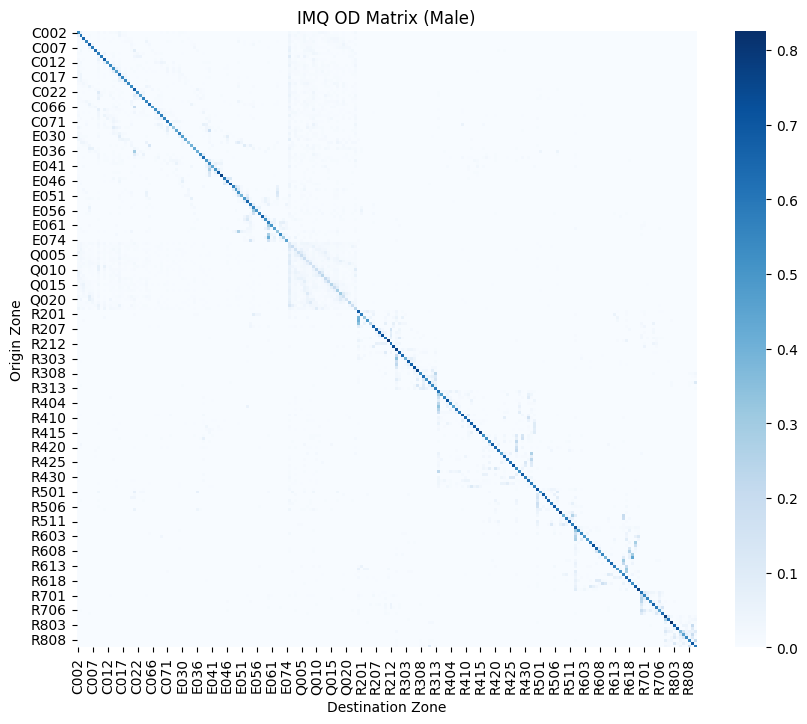

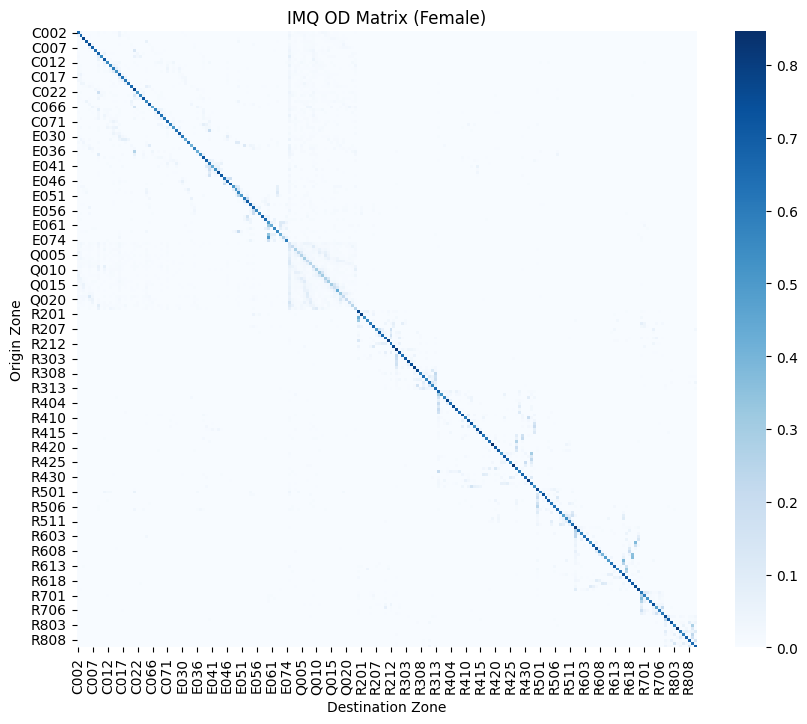

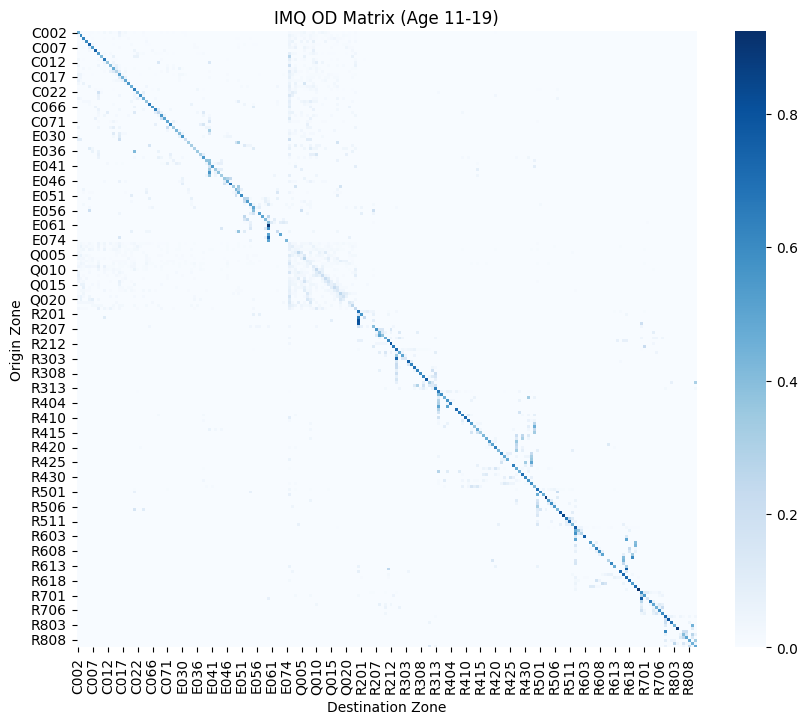

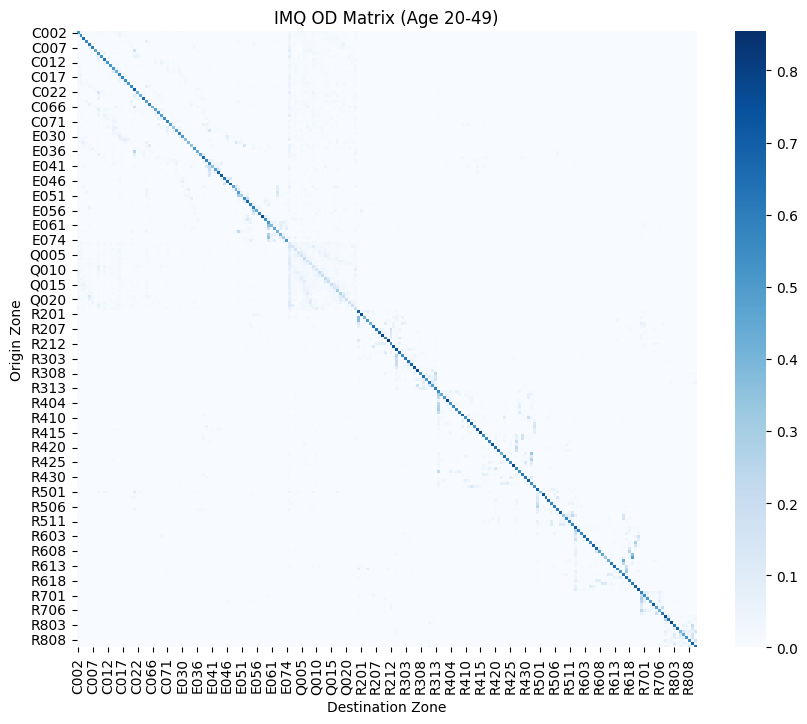

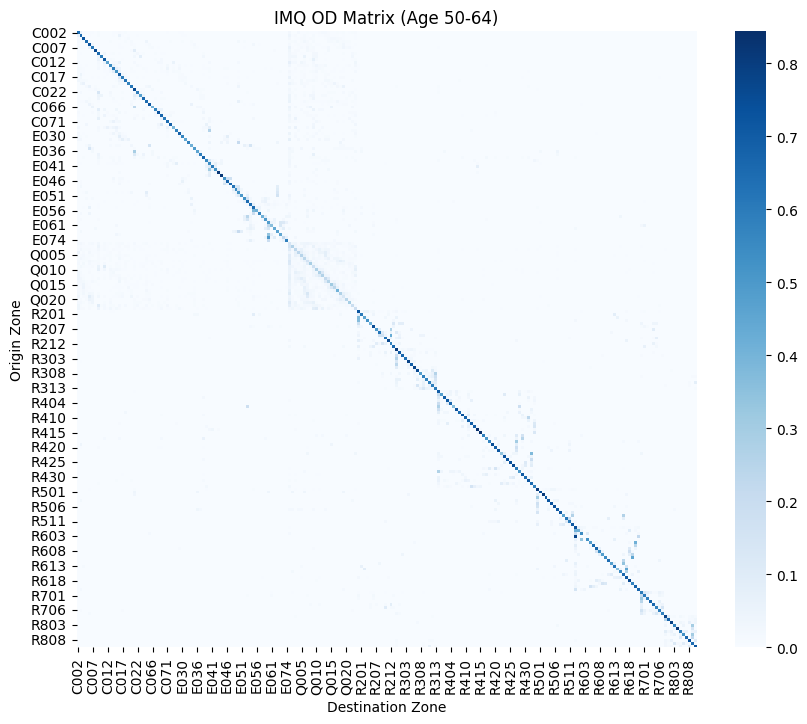

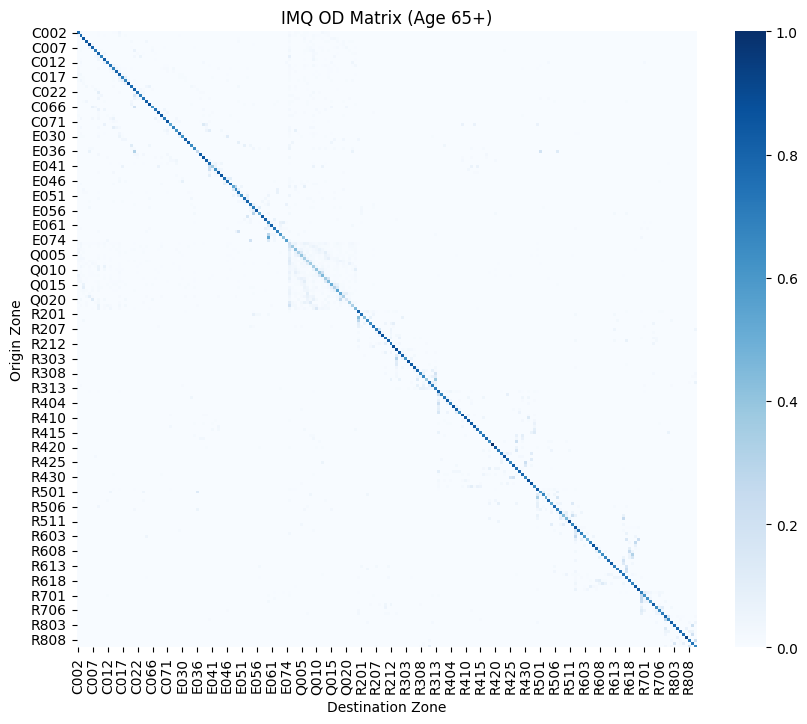

Similarity Score (Male vs Female): 0.9801323204841034
Similarity Score (Age 11-19 vs 20-49): 0.8760343652860919
Similarity Score (Age 50-64 vs 65+): 0.9542592626140298


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter Data and Compute OD Matrices
def filter_and_compute_od_matrix(data, filters, origin_col, destination_col):
    """
    Filters data by the given conditions and computes the OD matrix.
    Args:
        data: DataFrame containing trip data
        filters: Dictionary with column names and filter values
        origin_col: Column name for origin zones
        destination_col: Column name for destination zones
    Returns:
        Normalized OD matrix or None if no data matches the filters.
    """
    filtered_data = data
    for col, value in filters.items():
        filtered_data = filtered_data[filtered_data[col] == value]
    if filtered_data.empty:  # Handle empty filtered data
        print(f"No data found for filters: {filters}")
        return None
    od_matrix = compute_od_matrix(filtered_data, origin_col, destination_col)
    if od_matrix.empty:  # Handle empty OD matrix
        print(f"Empty OD matrix for filters: {filters}")
        return None
    return normalize_matrix(od_matrix)

# Step 2: Gender-based OD Matrices
imq_male_norm = filter_and_compute_od_matrix(imq_data, {'SESSO': 'Maschi'}, 'COD_ZONA_PAR', 'COD_ZONA_ARR')
imq_female_norm = filter_and_compute_od_matrix(imq_data, {'SESSO': 'Femmine'}, 'COD_ZONA_PAR', 'COD_ZONA_ARR')

# Step 3: Age Group-based OD Matrices
age_group_11_19 = filter_and_compute_od_matrix(imq_data, {'FASCIA_ETA': 1}, 'COD_ZONA_PAR', 'COD_ZONA_ARR')
age_group_20_49 = filter_and_compute_od_matrix(imq_data, {'FASCIA_ETA': 2}, 'COD_ZONA_PAR', 'COD_ZONA_ARR')
age_group_50_64 = filter_and_compute_od_matrix(imq_data, {'FASCIA_ETA': 3}, 'COD_ZONA_PAR', 'COD_ZONA_ARR')
age_group_65_plus = filter_and_compute_od_matrix(imq_data, {'FASCIA_ETA': 4}, 'COD_ZONA_PAR', 'COD_ZONA_ARR')

# Step 4: Plot OD Matrices
def plot_heatmap(matrix, title, xlabel='Destination Zone', ylabel='Origin Zone'):
    """
    Plots a heatmap of the OD matrix.
    """
    if matrix is None or matrix.empty:
        print(f"Cannot plot heatmap for {title}: Matrix is empty or None.")
        return
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, cmap='Blues', annot=False, cbar=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Plot gender-based OD matrices
plot_heatmap(imq_male_norm, "IMQ OD Matrix (Male)")
plot_heatmap(imq_female_norm, "IMQ OD Matrix (Female)")

# Plot age group-based OD matrices
plot_heatmap(age_group_11_19, "IMQ OD Matrix (Age 11-19)")
plot_heatmap(age_group_20_49, "IMQ OD Matrix (Age 20-49)")
plot_heatmap(age_group_50_64, "IMQ OD Matrix (Age 50-64)")
plot_heatmap(age_group_65_plus, "IMQ OD Matrix (Age 65+)")

# Step 5: Compare Matrices (Optional)
# Example: Similarity comparison between gender-based matrices
if imq_male_norm is not None and imq_female_norm is not None:
    similarity_gender = compute_similarity(imq_male_norm, imq_female_norm)
    print(f"Similarity Score (Male vs Female): {similarity_gender}")

# Example: Similarity comparison between age groups
if age_group_11_19 is not None and age_group_20_49 is not None:
    similarity_11_19_vs_20_49 = compute_similarity(age_group_11_19, age_group_20_49)
    print(f"Similarity Score (Age 11-19 vs 20-49): {similarity_11_19_vs_20_49}")

if age_group_50_64 is not None and age_group_65_plus is not None:
    similarity_50_64_vs_65_plus = compute_similarity(age_group_50_64, age_group_65_plus)
    print(f"Similarity Score (Age 50-64 vs 65+): {similarity_50_64_vs_65_plus}")
